In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import operator
import os

In [4]:
BASE_DIR='./outputs/second'
SUBFAMILY_SIZE=5

In [5]:
OUTPUT_DIR = "./plot_builder_output"
os.makedirs(f"{OUTPUT_DIR}/heatmaps", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/lineplot", exist_ok=True)

In [6]:
def make_heatmap(results : dict, our_results : dict, title : str, baseline : str, minimizing = True, add_whole_family_value = True):
    values = np.array([list(item[-2].values()) for train, item in results.items()]).squeeze(axis=-1)
    values[~np.isfinite(values)] = np.nan
    # if add_whole_family_value:
        # entire_family_values = np.array([item[-1] for train, item in results.items()])
        # values = np.hstack([values, entire_family_values[..., None]])
    values = np.vstack([values, our_results['ours']])
    if add_whole_family_value:
        entire_family_values = np.array([item[-1] if item[-1] is not None else np.nan for train, item in results.items()] + [our_results['whole_family']])
        # entire_family_values[~np.isfinite(entire_family_values)] = np.nan
        values = np.hstack([values, entire_family_values[..., None]])
    plt.figure(figsize=(16,9))
    
    ax = sns.heatmap(values, annot=True, vmin=np.nanmin(values), vmax=np.nanmax(values), cmap=sns.cm.rocket_r if minimizing else sns.cm.rocket, mask=~np.isfinite(values), fmt='.2f')
    
    # if add_whole_family_value:
        # ax.add_patch(Rectangle((0,0), 10, 11, fill=False, edgecolor='white', lw=3)) # White bounding box
    
    subfamily_size = len(results.keys())
    
    best_value = np.inf if minimizing else -np.inf
    for r in range(values.shape[0]):
        row_values = values[r][:-1] if add_whole_family_value else values[r]
        idx = np.nanargmax(row_values) if minimizing else np.nanargmin(row_values)
        cmp = operator.le if minimizing else operator.ge
        if cmp(row_values[idx], best_value):
            best_value = row_values[idx]
            best_rectangle = (idx, r)
        ax.add_patch(Rectangle((idx, r),1,1, fill=False, edgecolor='blue', lw=3))
    ax.add_patch(Rectangle(best_rectangle,1,1, fill=False, edgecolor='green', lw=3))
    
    if add_whole_family_value:
        best_family_idx = np.nanargmin(values[:, -1]) if minimizing else np.nanargmax(values[:, -1])
        ax.add_patch(Rectangle((subfamily_size, best_family_idx),1,1, fill=False, edgecolor='green', lw=3))
    
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")
    plt.yticks(rotation=0) 
    xticks = [f"{i}" for i in range(subfamily_size)]
    if add_whole_family_value:
        xticks += ["Entire family"]
    ax.set_xticklabels(xticks) 
    ax.set_yticklabels([f"{baseline} on {i} ({results[i][1].num_nodes}-FSC)" for i in range(subfamily_size)] + ["Ours: GD on (sub)family"])
    ax.set_title(f"{title}: {baseline} vs Ours ({'lower' if minimizing else 'higher'} is better)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/heatmaps/{title}-{baseline}.png")

In [7]:
def make_lineplot(results : dict, title : str = 'Placeholder', minimizing = True, type_of_plot = 'family_trace'):
    plt.figure()
    plt.title(f"{title} ({'lower' if minimizing else 'higher'} is better)")
    plt.xlabel("Iteration")
    plt.ylabel("Worst family member value")
    plt.plot(results['gd-normal'][type_of_plot], label='Paynt GD')
    plt.plot(results['gd-no-momentum'][type_of_plot], label='Paynt GD (no momentum)')
    plt.plot(results['gd-random'][type_of_plot], label='Random GD')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/lineplot/{title}.png")

[Errno 2] No such file or directory: 'outputs/avoid/gd-experiment.pickle'


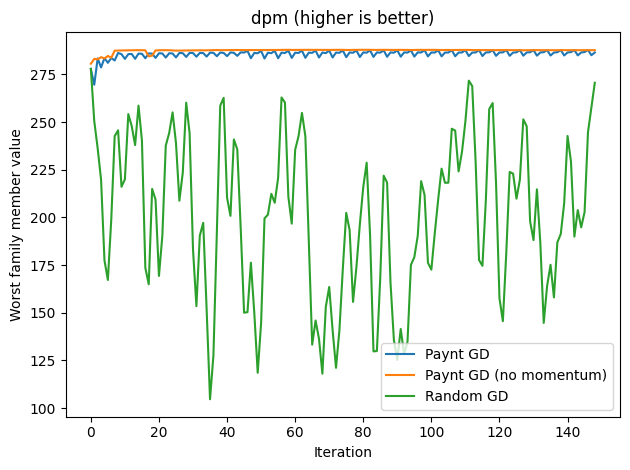

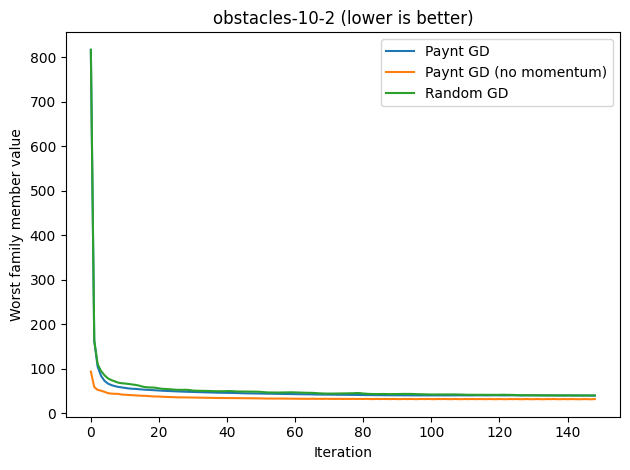

In [8]:
for env in ['dpm', 'obstacles-10-2', 'avoid']:
    try:
        with open(f"outputs/{env}/gd-experiment.pickle", 'rb') as handle:
            results = pickle.load(handle)
            make_lineplot(results, title=env, minimizing='dpm' not in env.lower())
    except FileNotFoundError as fnfe:
        print(fnfe)

# DPM

timeout = 10s

In [9]:
dpm_our = [504.76099479, 496.6463078,  522.29707964, 471.26597349, 483.96767624,
 463.09737765, 294.67001291, 498.28841493, 510.35243059, 509.71750883]

In [10]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [11]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [12]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print(i, fsc.num_nodes)
    for j in range(fsc.num_nodes):
        print(fsc.update_function[j])

0 3
[{0: 1.0}, {1: 1.0}, {0: 1.0}]
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
[{2: 1.0}, {0: 1.0}, {0: 1.0}]
1 3
[{1: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {2: 1.0}, {0: 1.0}]
[{0: 1.0}, {2: 1.0}, {0: 1.0}]
2 3
[{2: 1.0}, {1: 1.0}, {0: 1.0}]
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
[{0: 1.0}, {2: 1.0}, {0: 1.0}]
3 3
[{0: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {0: 1.0}, {0: 1.0}]
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
4 3
[{2: 1.0}, {1: 1.0}, {0: 1.0}]
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
[{0: 1.0}, {2: 1.0}, {0: 1.0}]


In [13]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [14]:
ours

{'ours': array([756.09204367, 894.86030694, 981.99589767, 756.53247732,
        856.28978993]),
 'whole_family': 201.94264759045433,
 'fsc': <paynt.quotient.fsc.FSC at 0x7f85ce3b43e0>}

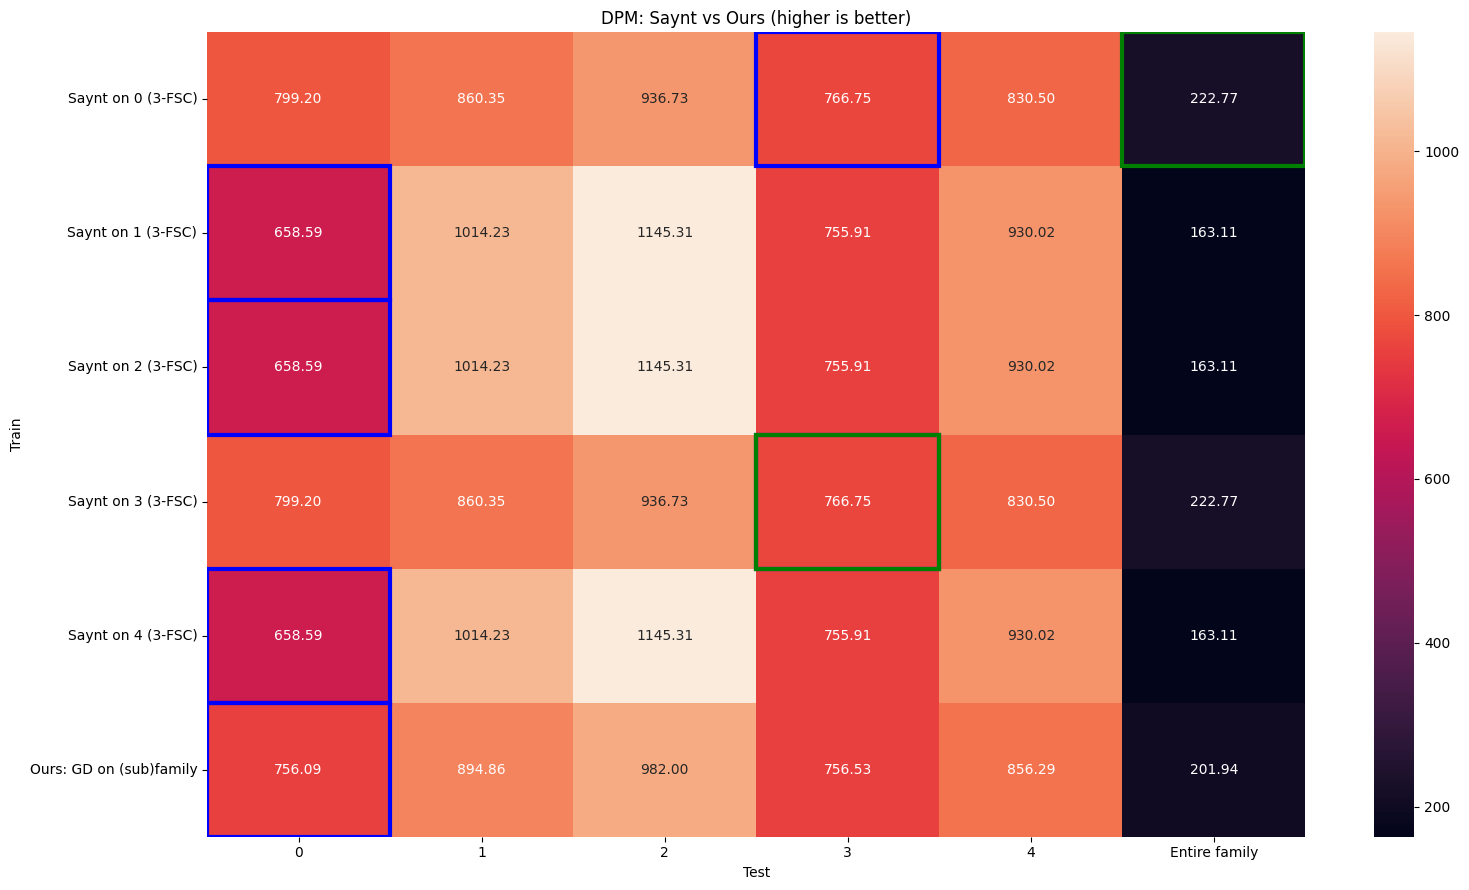

In [15]:
make_heatmap(subfamily_saynt_results, ours, "DPM", "Saynt", minimizing=False)

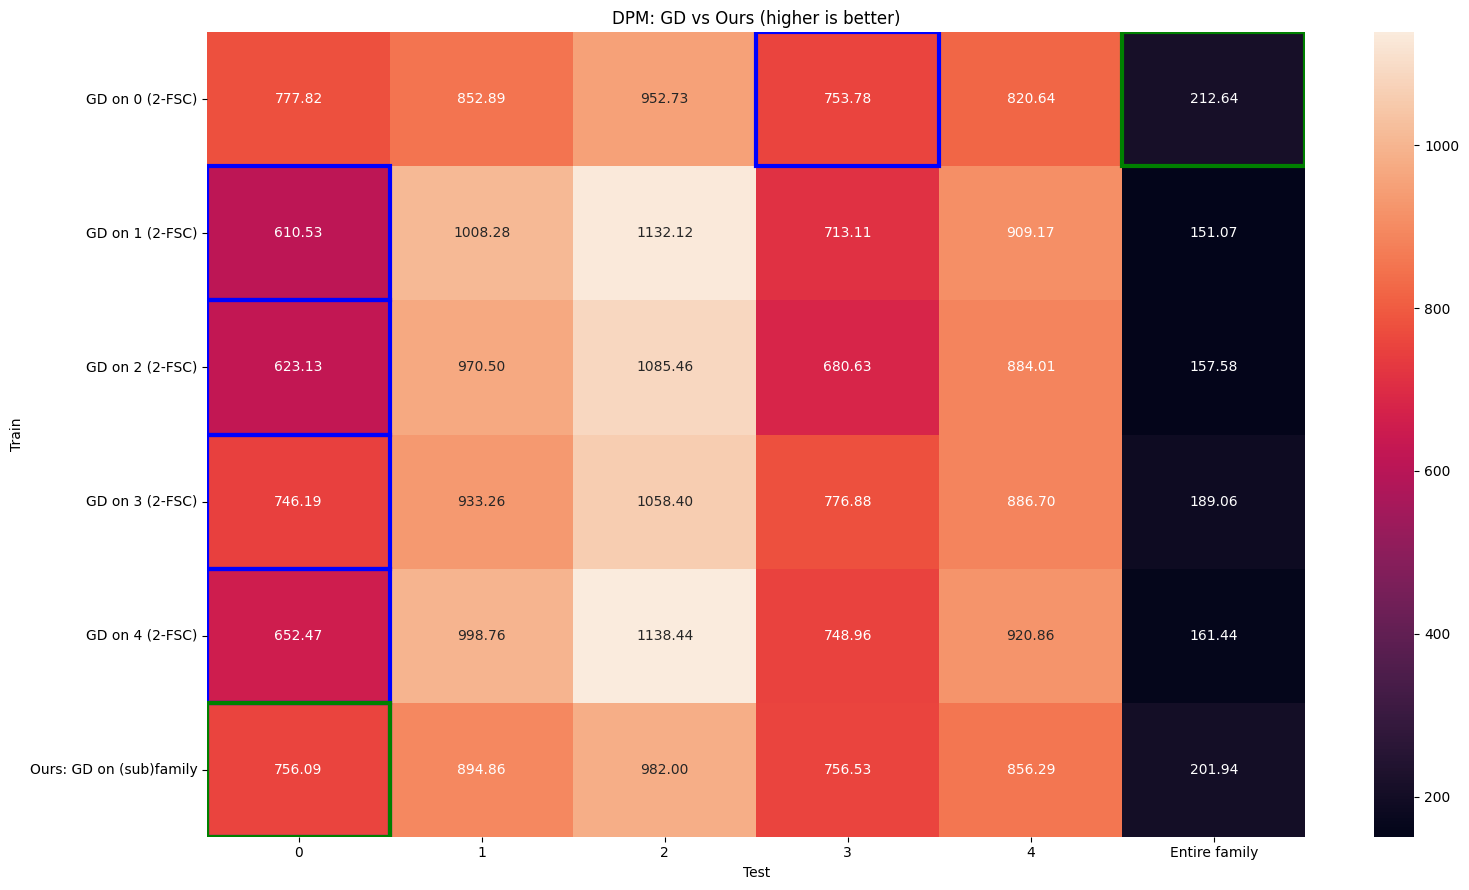

In [16]:
make_heatmap(subfamily_gd_results, ours, "DPM", "GD", minimizing=False)

# OBSTACLES 8 3

timeout = 30s

In [17]:
with open("{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    saynt = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/saynt.pickle'

In [ ]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    gradient = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [ ]:
make_heatmap(saynt, ours, "OBSTACLES(8,3)", "Saynt")

## Gradient baseline

In [ ]:
make_heatmap(gradient, ours, "OBSTACLES(8,3)", "GD")

# OBSTACLES 10 2

timeout = 10s

In [ ]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [ ]:
print("Obstacles(10, 2):")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

Obstacles(10, 2):


NameError: name 'SUBFAMILY_SIZE' is not defined

In [ ]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

NameError: name 'BASE_DIR' is not defined

In [ ]:
ours_raw = [27.85853738, 28.71888006, 30.78940948, 28.75065993, 29.3297606,  30.77959397,
 29.48840814, 29.3297606,  28.22878829, 30.14997737]

In [ ]:
ours

{'ours': array([24.64096438, 24.80545503, 23.66741041, 23.65028479, 24.79264997]),
 'whole_family': 34.76319004545299,
 'fsc': <paynt.quotient.fsc.FSC at 0x7f2a45d15670>}

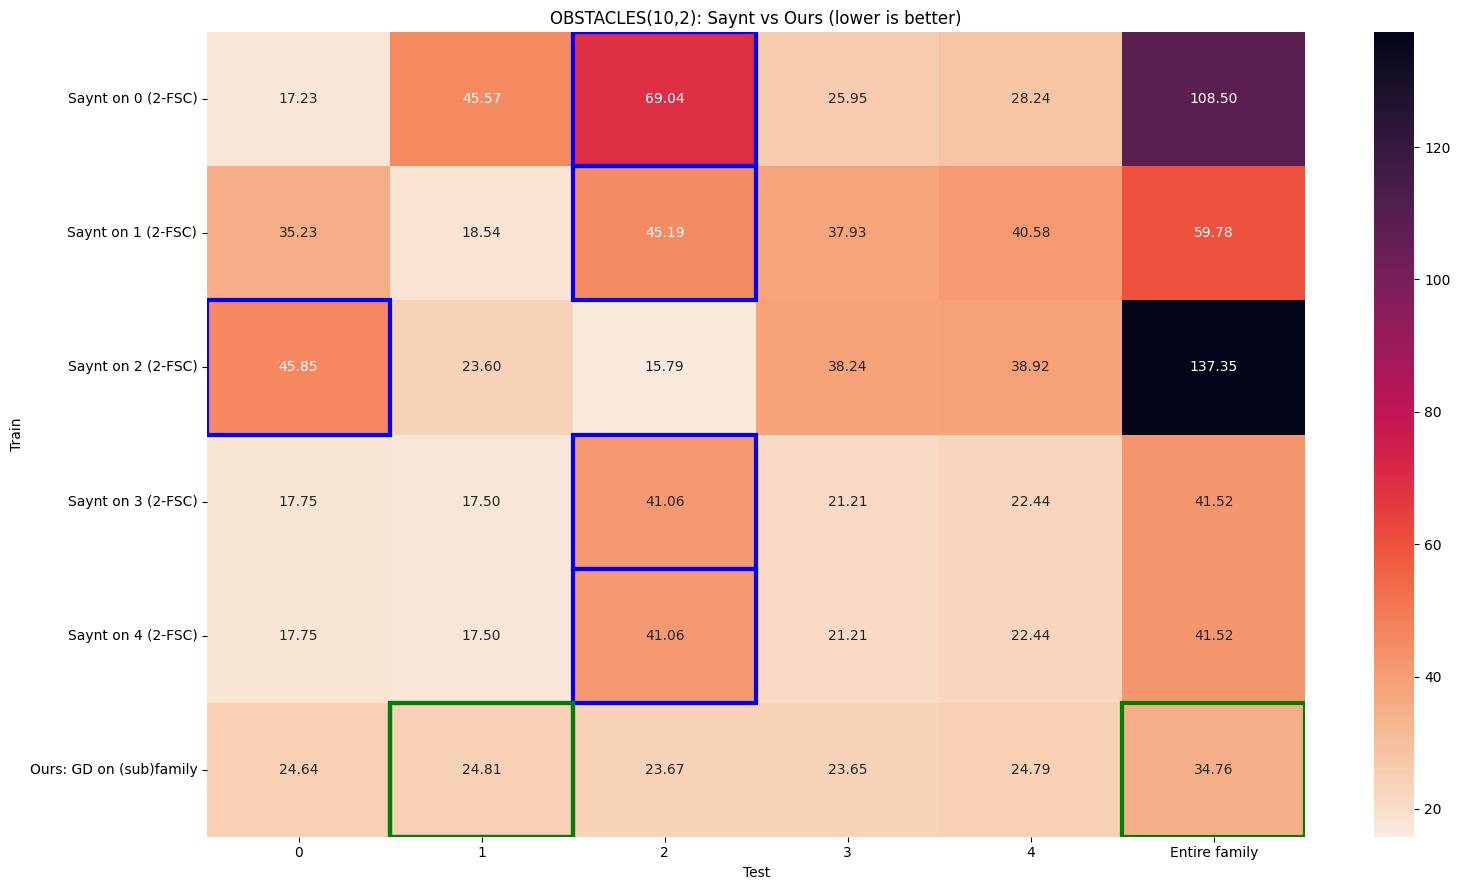

In [ ]:
make_heatmap(subfamily_saynt_results, ours, "OBSTACLES(10,2)", "Saynt")

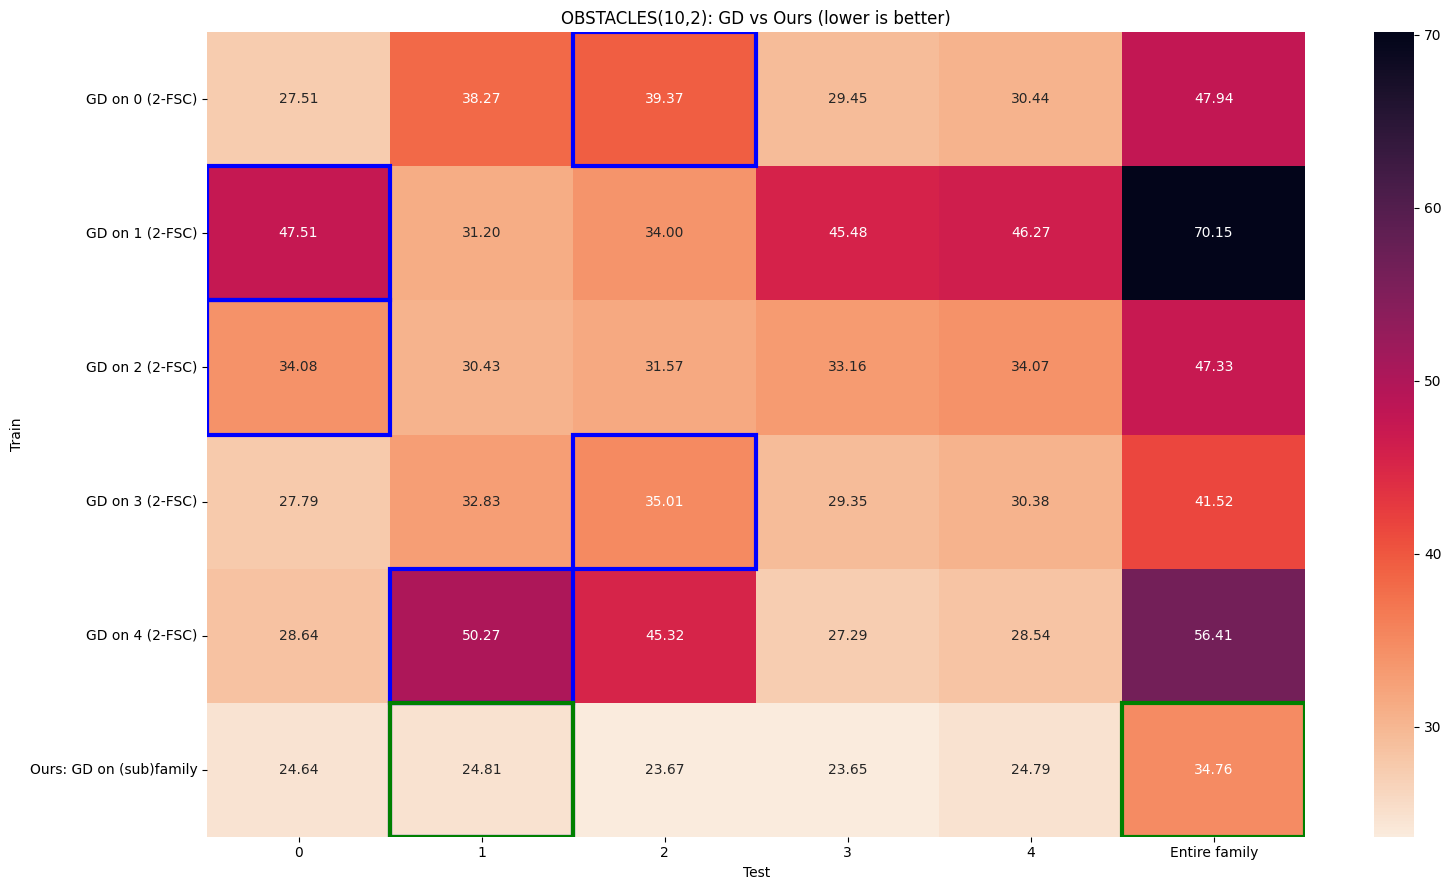

In [ ]:
make_heatmap(subfamily_gd_results, ours, "OBSTACLES(10,2)", "GD")

# AVOID

timeout = 60s

In [ ]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [ ]:
ours

{'ours': array([ 70.55771323,  46.88237022,  66.0884114 , 100.19440758,
         62.65578522]),
 'whole_family': 208.32608128190074,
 'fsc': <paynt.quotient.fsc.FSC at 0x7f2a45c9ae10>}

In [ ]:
# with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/paynt.pickle", 'rb') as handle:
#     subfamily_paynt_results = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [ ]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_gd_results[i][1]
    print(i, fsc.update_function)

0 [[{0: 0.6178580955799288, 1: 0.38214190442007123}, {0: 0.5437065394616526, 1: 0.45629346053834735}, {0: 0.3637398176489581, 1: 0.6362601823510419}, {0: 0.07670264077436342, 1: 0.9232973592256366}, {0: 0.23536289258765683, 1: 0.7646371074123433}, {0: 0.5537626183312014, 1: 0.4462373816687986}, {0: 0.8007624834480523, 1: 0.19923751655194766}, {0: 0.101005090237692, 1: 0.898994909762308}, {0: 0.4744840434557593, 1: 0.5255159565442407}, {0: 0.21086282386947588, 1: 0.789137176130524}, {0: 0.554054728040355, 1: 0.44594527195964506}], [{0: 0.6334718048670479, 1: 0.366528195132952}, {0: 0.9121308061140956, 1: 0.08786919388590442}, {0: 0.6248572030385923, 1: 0.37514279696140773}, {0: 0.00954786990081035, 1: 0.9904521300991896}, {0: 0.05549044284693946, 1: 0.9445095571530606}, {0: 0.005618216135489813, 1: 0.9943817838645101}, {0: 0.13799929878068137, 1: 0.8620007012193185}, {0: 0.012931368618273235, 1: 0.9870686313817268}, {0: 0.059401832379376136, 1: 0.9405981676206239}, {0: 0.059759751971757

In [ ]:
print("AVOID:")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

AVOID:
POMDP 0 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
POMDP 1 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
POMDP 2 with a 4-FSC. Memory model: [1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1]
POMDP 3 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
POMDP 4 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
l = [51.94674404, 65.42364497, 63.76348781, 98.68745545, 32.52550974, 67.09607064,
 87.41523619, 64.81453459, 53.95332456, 56.50783793]

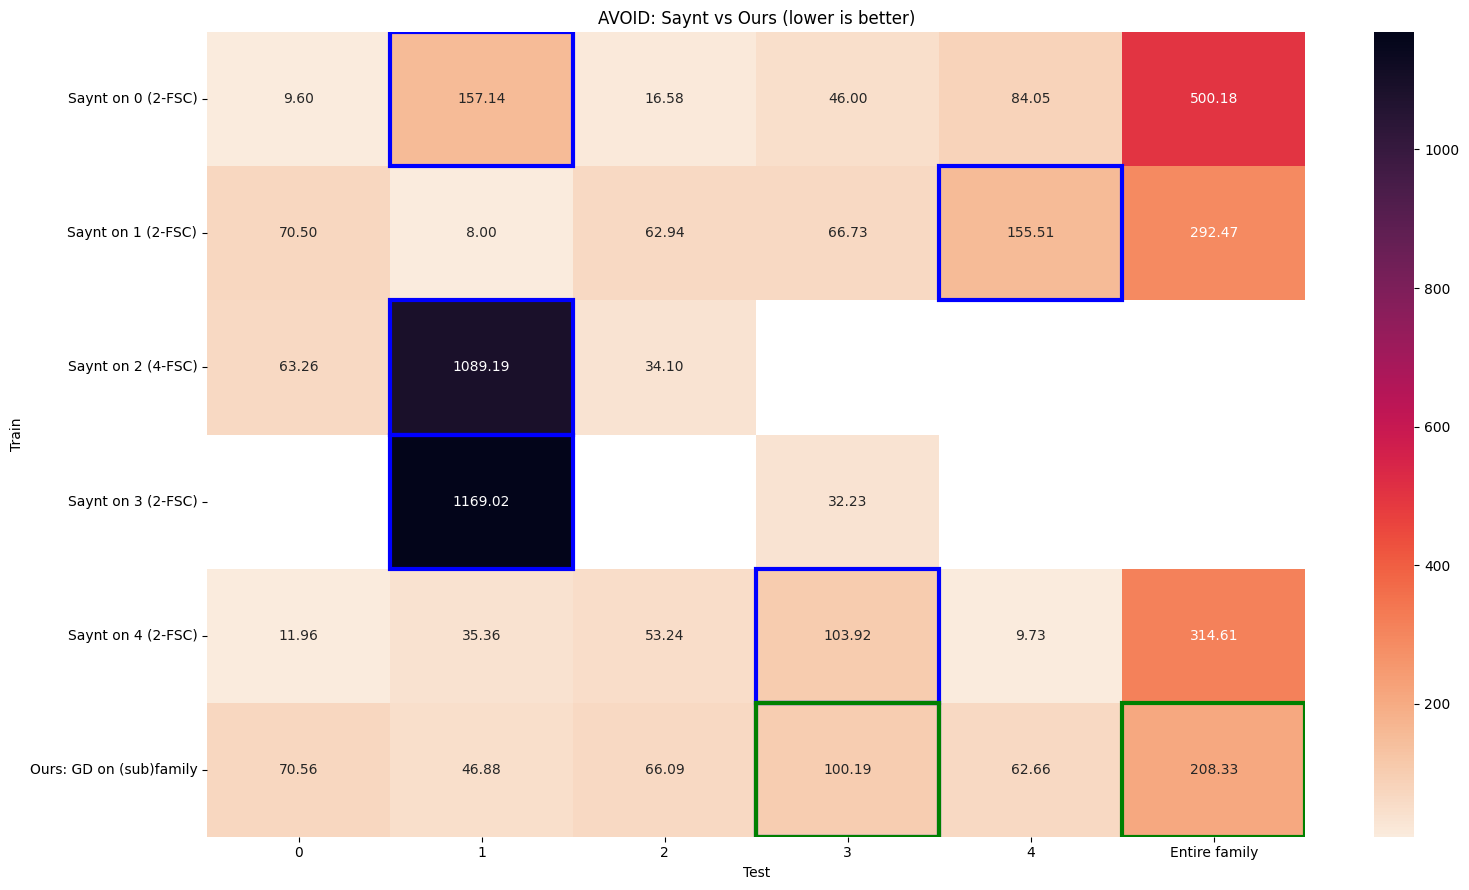

In [ ]:
make_heatmap(subfamily_saynt_results, ours, "AVOID", "Saynt")

In [ ]:
# make_heatmap(subfamily_paynt_results, ours, "AVOID", "Paynt")

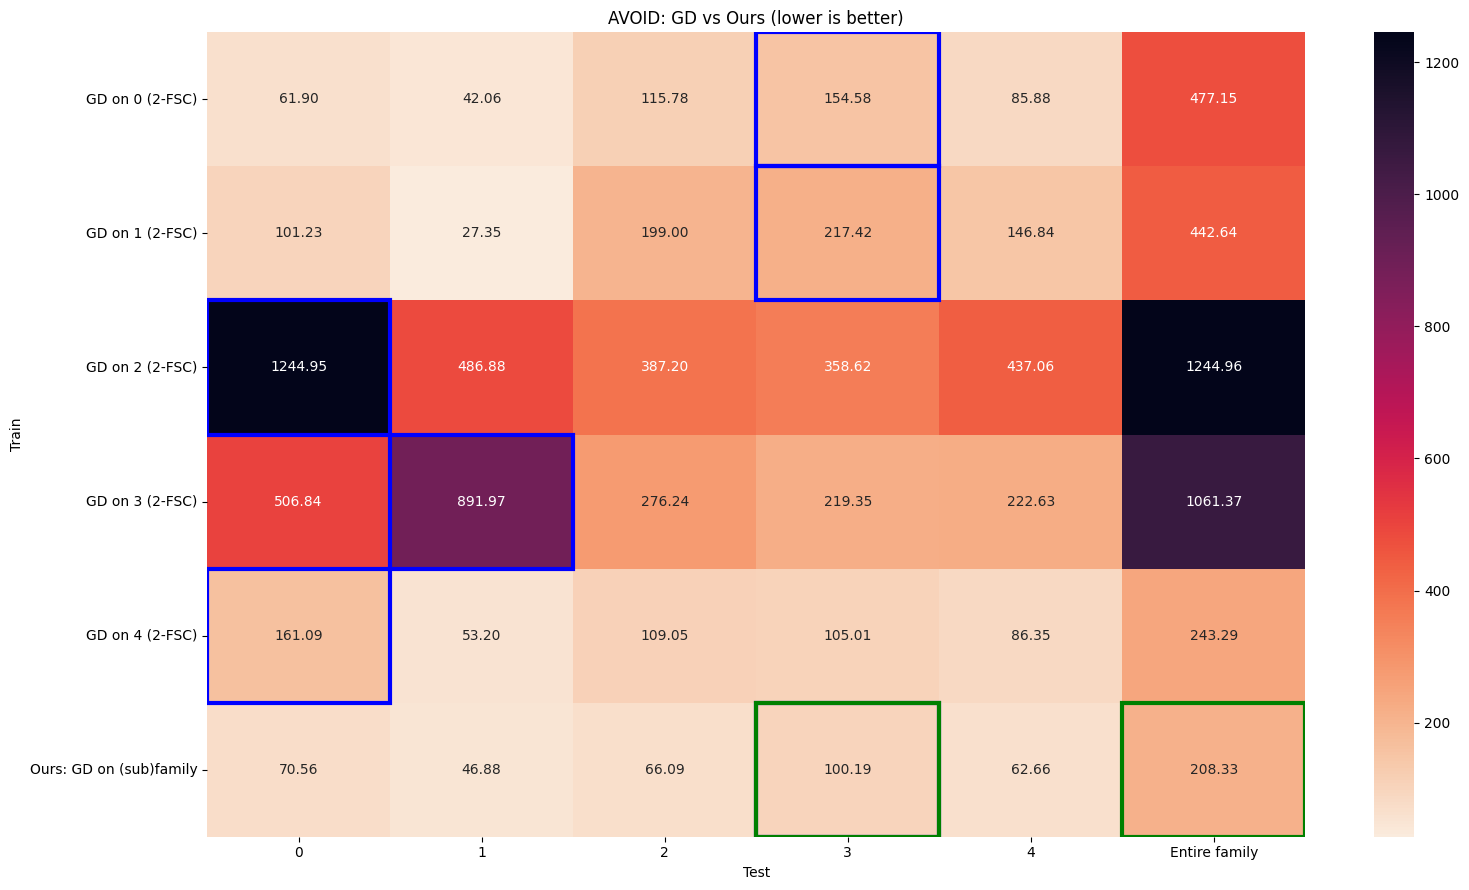

In [ ]:
make_heatmap(subfamily_gd_results, ours, "AVOID", "GD")